In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout, ReLU, Add, BatchNormalization, Multiply, GlobalAveragePooling2D, Reshape,DepthwiseConv2D
from keras.optimizers import Adam
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.metrics import Metric,Precision, Recall
import cv2
import numpy as np

In [2]:
train_dir = r'E:\MV\coursework\fruits-360\Training'
test_dir = r'E:\MV\coursework\fruits-360\Test'
#The total number of images: 90483.
#Training set size: 67692 images (one fruit or vegetable per image).
#Test set size: 22688 images (one fruit or vegetable per image).
#The number of classes: 131 (fruits and vegetables).
#Image size: 100x100 pixels.

In [3]:
#find out the total calsses of dataset.
className = glob.glob(train_dir + "/*")
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  131



Training:554190

Validation:13502

Test:22688

ratio: 60%:15%:25% 

In [4]:
def denoise_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    np.copyto(image, thresh_rgb, where=thresh_rgb == 255)
    return image
# Load and preprocess the training data
train_datagen1 = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

train_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)
test_datagen1 = ImageDataGenerator(rescale=1.0/255)
test_generator1 = test_datagen1.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.



Training:58613

Validation:9079

Test:22688

ratio: 65%:10%:25% 

In [5]:
# Load and preprocess the training data
train_datagen2 = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.135,
    fill_mode='nearest'
)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)
test_datagen2 = ImageDataGenerator(rescale=1.0/255)
test_generator2 = test_datagen2.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 58613 images belonging to 131 classes.
Found 9079 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.




Training:63145

Validation:4547

Test:22688

ratio: 70%:5%:25% 

In [6]:
# Load and preprocess the training data
train_datagen3 = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)
train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)
test_datagen3 = ImageDataGenerator(rescale=1.0/255)
test_generator3 = test_datagen3.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [7]:
input_shape = Input(shape=(100,100,3))

In [8]:
class CustomAccuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        correct_predictions = tf.equal(y_pred_classes, y_true_classes)
        correct_predictions = tf.cast(correct_predictions, 'float32')
        
        self.correct.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.cast(tf.size(y_true_classes), 'float32'))

    def result(self):
        return tf.divide(self.correct, self.total)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)
        
class CustomCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, name='loss', **kwargs):
        super(CustomCrossEntropyLoss, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        epsilon = 1e-10
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        return loss


In [9]:
def se_block(input_tensor, ratio=16):
# Squeeze-and-Excitation block
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    scaled_input = Multiply()([input_tensor, se])
    return scaled_input

def inception_block(x, br1, br2_1, br2_2, br3_1, br3_2, br4):
    # Branch 1
    branch1 = Conv2D(br1, (1, 1), padding='same', activation='relu')(x)
    # Branch 2 3x3-> 1x3 3x1
    branch2 = Conv2D(br2_1, (1, 1), padding='same', activation='relu')(x)
    #branch2 = Conv2D(br2_2, (3, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (1, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (3, 1), padding='same', activation='relu')(branch2)
    # Branch 3 5x5->3x3 3x3-> 1x3 3x1 1x3 3x1 
    branch3 = Conv2D(br3_1, (1, 1), padding='same', activation='relu')(x)
    #branch3 = Conv2D(br3_2, (5, 5), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    # Branch 4
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(br4, (1, 1), padding='same', activation='relu')(branch4)
    # Concatenate all the branches
    branch_output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    # After the Inception block, apply the SE block
    branch_output = se_block(branch_output)
    return branch_output

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_shape)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 64, 96, 64, 16, 32, 32)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 128, 128, 128, 32, 64, 64)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 160, 160, 160, 48, 96, 96)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
# Final layers
x = GlobalAveragePooling2D()(x)
output = Dense(numberOfClass, activation='softmax')(x)
model_1 = Model(inputs=input_shape, outputs=output)


def res_block(input_tensor, filters, strides=1):
    shortcut = input_tensor

    # First component of main path
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second component of main path
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third component of main path
    x = Conv2D(filters * 4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)

    # Shortcut path
    if strides != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Final step: Add shortcut value to main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def combined_model():

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2,2)(x)

    x = res_block(x, filters=64, strides=1)
    x = res_block(x, filters=128, strides=2)
    x = res_block(x, filters=256, strides=2)
    x = res_block(x, filters=512, strides=2)
    x = MaxPooling2D(2,2)(x)

    x = GlobalAveragePooling2D()(x)
    output = Dense(numberOfClass, activation='softmax')(x)

    model_2 = Model(inputs=input_shape, outputs=output)
    concatenated_output= concatenate([model_1.output, model_2.output])

    x = Dense(256, activation='relu')(concatenated_output)
    x = Dropout(0.3)(x)
    x= Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    ensemble_output= Dense(numberOfClass, activation='softmax')(x)
    #Build the ensemble model
    combined_model = Model(inputs=input_shape, outputs= ensemble_output)
    return combined_model

In [10]:
model_instance1=combined_model()
model_instance1.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_1 = model_instance1.fit(train_generator1, validation_data=validation_generator1, epochs=10)

Epoch 1/10
1694/1694 [==============================] - 388s 224ms/step - loss: 2.8232 - accuracy: 0.1951 - val_loss: 1.6935 - val_accuracy: 0.4016
Epoch 2/10
1694/1694 [==============================] - 399s 235ms/step - loss: 1.1343 - accuracy: 0.5957 - val_loss: 0.6078 - val_accuracy: 0.8340
Epoch 3/10
1694/1694 [==============================] - 292s 172ms/step - loss: 0.5169 - accuracy: 0.8206 - val_loss: 0.7030 - val_accuracy: 0.8064
Epoch 4/10
1694/1694 [==============================] - 292s 172ms/step - loss: 0.2978 - accuracy: 0.9001 - val_loss: 0.3056 - val_accuracy: 0.9205
Epoch 5/10
1694/1694 [==============================] - 292s 172ms/step - loss: 0.2119 - accuracy: 0.9299 - val_loss: 0.1775 - val_accuracy: 0.9582
Epoch 6/10
1694/1694 [==============================] - 293s 173ms/step - loss: 0.1684 - accuracy: 0.9455 - val_loss: 0.2518 - val_accuracy: 0.9273
Epoch 7/10
1694/1694 [==============================] - 293s 173ms/step - loss: 0.1327 - accuracy: 0.9586 - val_

In [11]:
model_instance2=combined_model()
model_instance2.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_2 = model_instance2.fit(train_generator2, validation_data=validation_generator2, epochs=10)

Epoch 1/10
1832/1832 [==============================] - 312s 168ms/step - loss: 1.3079 - accuracy: 0.5889 - val_loss: 0.4773 - val_accuracy: 0.8394
Epoch 2/10
1832/1832 [==============================] - 304s 166ms/step - loss: 0.2938 - accuracy: 0.8995 - val_loss: 0.2104 - val_accuracy: 0.9346
Epoch 3/10
1832/1832 [==============================] - 304s 166ms/step - loss: 0.1258 - accuracy: 0.9635 - val_loss: 0.1091 - val_accuracy: 0.9715
Epoch 4/10
1832/1832 [==============================] - 303s 166ms/step - loss: 0.0864 - accuracy: 0.9759 - val_loss: 0.1925 - val_accuracy: 0.9553
Epoch 5/10
1832/1832 [==============================] - 303s 166ms/step - loss: 0.0692 - accuracy: 0.9809 - val_loss: 0.1730 - val_accuracy: 0.9629
Epoch 6/10
1832/1832 [==============================] - 303s 165ms/step - loss: 0.0643 - accuracy: 0.9816 - val_loss: 0.3361 - val_accuracy: 0.9366
Epoch 7/10
1832/1832 [==============================] - 304s 166ms/step - loss: 0.0558 - accuracy: 0.9843 - val_

In [35]:
model_instance3=combined_model()
model_instance3.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_3 = model_instance3.fit(train_generator3, validation_data=validation_generator3, epochs=10)

Epoch 1/10
1974/1974 [==============================] - 527s 264ms/step - loss: 0.8725 - accuracy: 0.7636 - val_loss: 0.1816 - val_accuracy: 0.9551
Epoch 2/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.1612 - val_accuracy: 0.9642
Epoch 3/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0580 - accuracy: 0.9829 - val_loss: 0.1943 - val_accuracy: 0.9549
Epoch 4/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0499 - accuracy: 0.9849 - val_loss: 0.0621 - val_accuracy: 0.9784
Epoch 5/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0415 - accuracy: 0.9887 - val_loss: 0.0542 - val_accuracy: 0.9875
Epoch 6/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0344 - accuracy: 0.9911 - val_loss: 0.0218 - val_accuracy: 0.9947
Epoch 7/10
1974/1974 [==============================] - 314s 159ms/step - loss: 0.0371 - accuracy: 0.9907 - val_

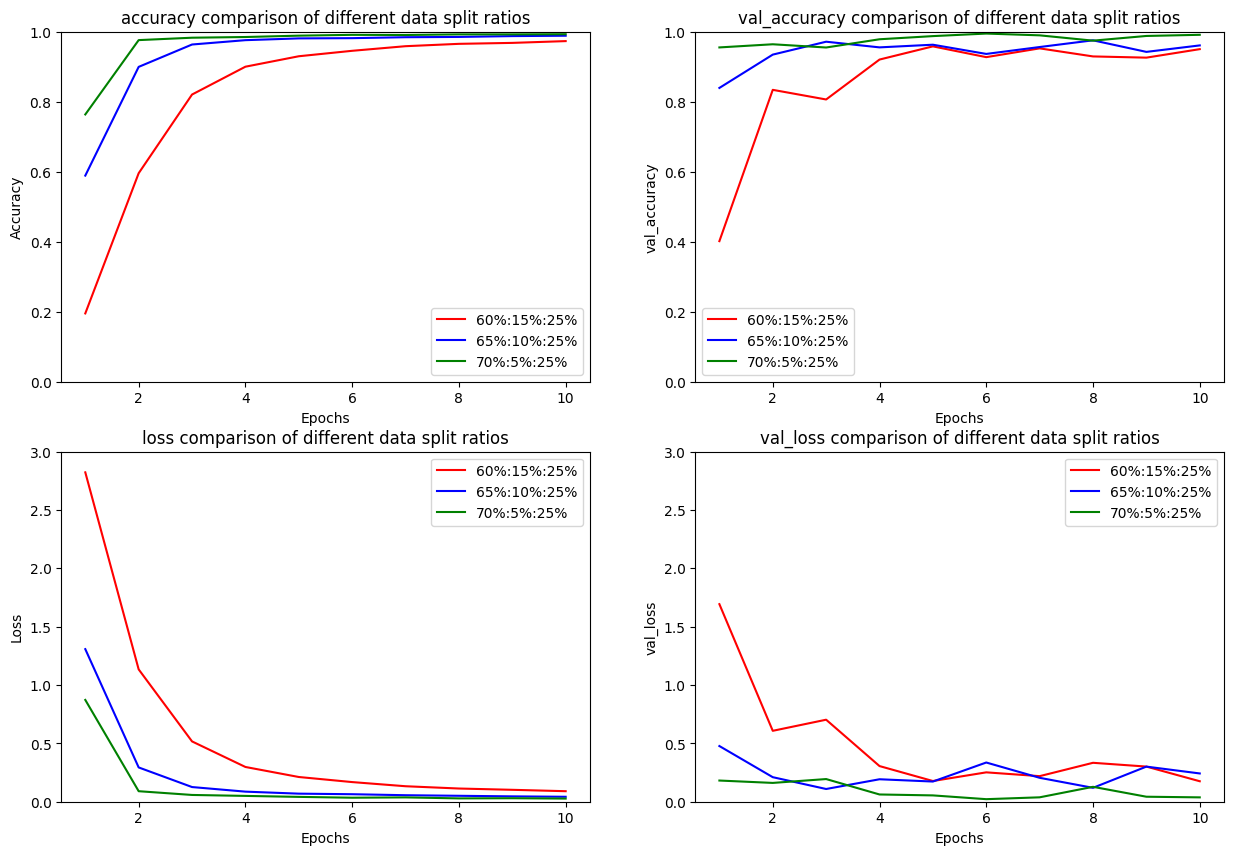

In [41]:
acc_1, loss_1 = history_1.history['accuracy'], history_1.history['loss']
acc_2, loss_2 = history_2.history['accuracy'], history_2.history['loss']
acc_3, loss_3 = history_3.history['accuracy'], history_3.history['loss']
val_acc_1, val_loss_1 = history_1.history['val_accuracy'], history_1.history['val_loss']
val_acc_2, val_loss_2 = history_2.history['val_accuracy'], history_2.history['val_loss']
val_acc_3, val_loss_3 = history_3.history['val_accuracy'], history_3.history['val_loss']

#generate the comparison graph
epochs = range(1, 11)  
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, acc_1, label='60%:15%:25%', color='red')
plt.plot(epochs, acc_2, label='65%:10%:25%', color='blue')
plt.plot(epochs, acc_3, label='70%:5%:25%',color='green')
plt.title('accuracy comparison of different data split ratios')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, val_acc_1, label='60%:15%:25%', color='red')
plt.plot(epochs, val_acc_2, label='65%:10%:25%', color='blue')
plt.plot(epochs, val_acc_3, label='70%:5%:25%',color='green')
plt.title('val_accuracy comparison of different data split ratios')
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, loss_1, label='60%:15%:25%', color='red')
plt.plot(epochs, loss_2, label='65%:10%:25%', color='blue')
plt.plot(epochs, loss_3, label='70%:5%:25%',color='green')
plt.title('loss comparison of different data split ratios')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.0, 3.0)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, val_loss_1, label='60%:15%:25%', color='red')
plt.plot(epochs, val_loss_2, label='65%:10%:25%', color='blue')
plt.plot(epochs, val_loss_3, label='70%:5%:25%',color='green')
plt.title('val_loss comparison of different data split ratios')
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.ylim(0.0, 3.0)
plt.legend()

plt.show()



In [39]:
test_loss1, test_accuracy1 = model_instance1.evaluate(test_generator1)
test_loss2, test_accuracy2 = model_instance2.evaluate(test_generator2)
test_loss3, test_accuracy3 = model_instance3.evaluate(test_generator3)


709/709 [==============================] - 30s 43ms/step - loss: 0.1037 - accuracy: 0.9821


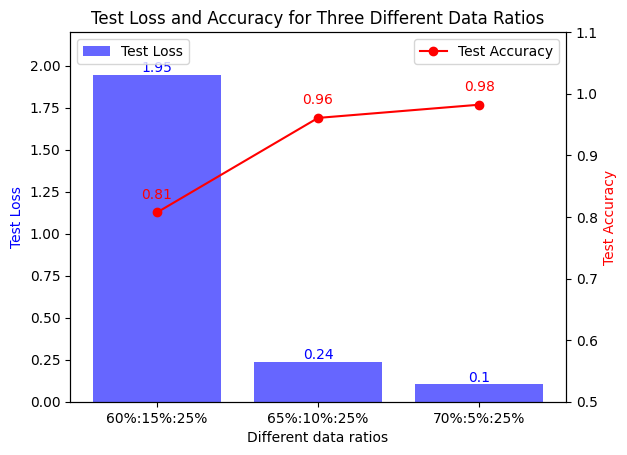

In [42]:
losses = [test_loss1, test_loss2, test_loss3]
accuracies = [test_accuracy1, test_accuracy2, test_accuracy3]
ratios = ['60%:15%:25%', '65%:10%:25%', '70%:5%:25%']

fig, ax1 = plt.subplots()

bars = ax1.bar(ratios, losses, color='b', alpha=0.6, label='Test Loss')

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', color='b')


ax2 = ax1.twinx()
line, = ax2.plot(ratios, accuracies, color='r', marker='o', label='Test Accuracy')


for i, txt in enumerate(accuracies):
    ax2.annotate(round(txt, 2), (ratios[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center', color='r')

ax2.set_ylim(bottom=0.5,top=1.1)
ax1.set_ylim(bottom=0, top=2.2)

ax1.set_xlabel('Different data ratios')
ax1.set_ylabel('Test Loss', color='b')
ax2.set_ylabel('Test Accuracy', color='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Test Loss and Accuracy for Three Different Data Ratios')
plt.show()
